### Zadania

Lista składa się z dwóch sekcji: pierwsza (zadania 1 i 2) dotyczy metod detekcji krawędzi, druga (zadania 3 i 4) operacji na histogramach.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import norm, logistic

##### Zad. 1: Wyznaczenie gradientów

Wykonaj dla obrazu `coins` sztuczny obraz ilustrujący wielkość (moduł) wektora gradientu w danym punkcie. Do wyświetlenia użyj [mapy kolorów](https://matplotlib.org/stable/tutorials/colors/colormaps.html) `hot` do oznaczenia wielkości gradientu odpowiednim kolorem – im większa wartość, tym bardziej czerwony (_mapa ciepła_).

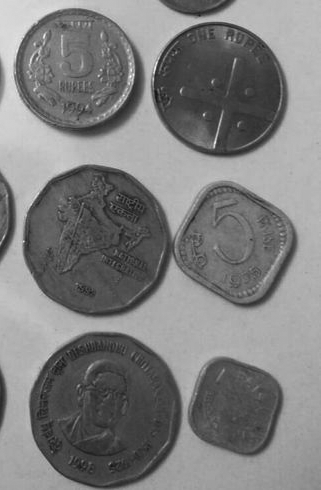

In [2]:
coins = cv2.imread('Monety_szare.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins)

Rozwiązanie:

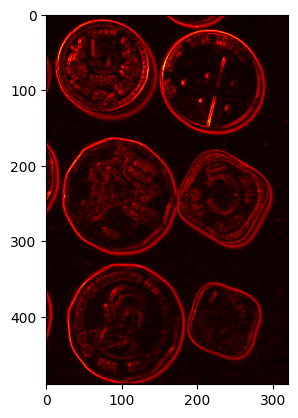

In [3]:
sobelx = cv2.Sobel(coins, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(coins, cv2.CV_64F, 0, 1, ksize=3)

magnitude = np.sqrt(sobelx**2 + sobely**2)

plt.imshow(magnitude, cmap='hot') # przykład wyświetlania z mapą kolorów

---

##### Zad. 2: Detekcja krawędzi

Przeprowadź z obrazem `coins_noise` takie przekształcenia, aby zmaksymalizować możliwość rozpoznania obiektów poprzez detekcję krawędzi. Wykorzystaj filtr Canny'ego dla różnych wartości progów oraz filtry redukcji szumu.

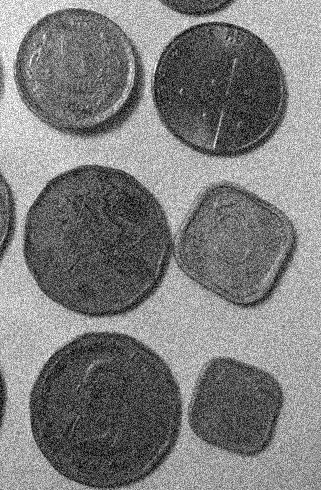

In [10]:
coins_noise = cv2.imread('Monety_szare_szum.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins_noise)

Rozwiązanie:

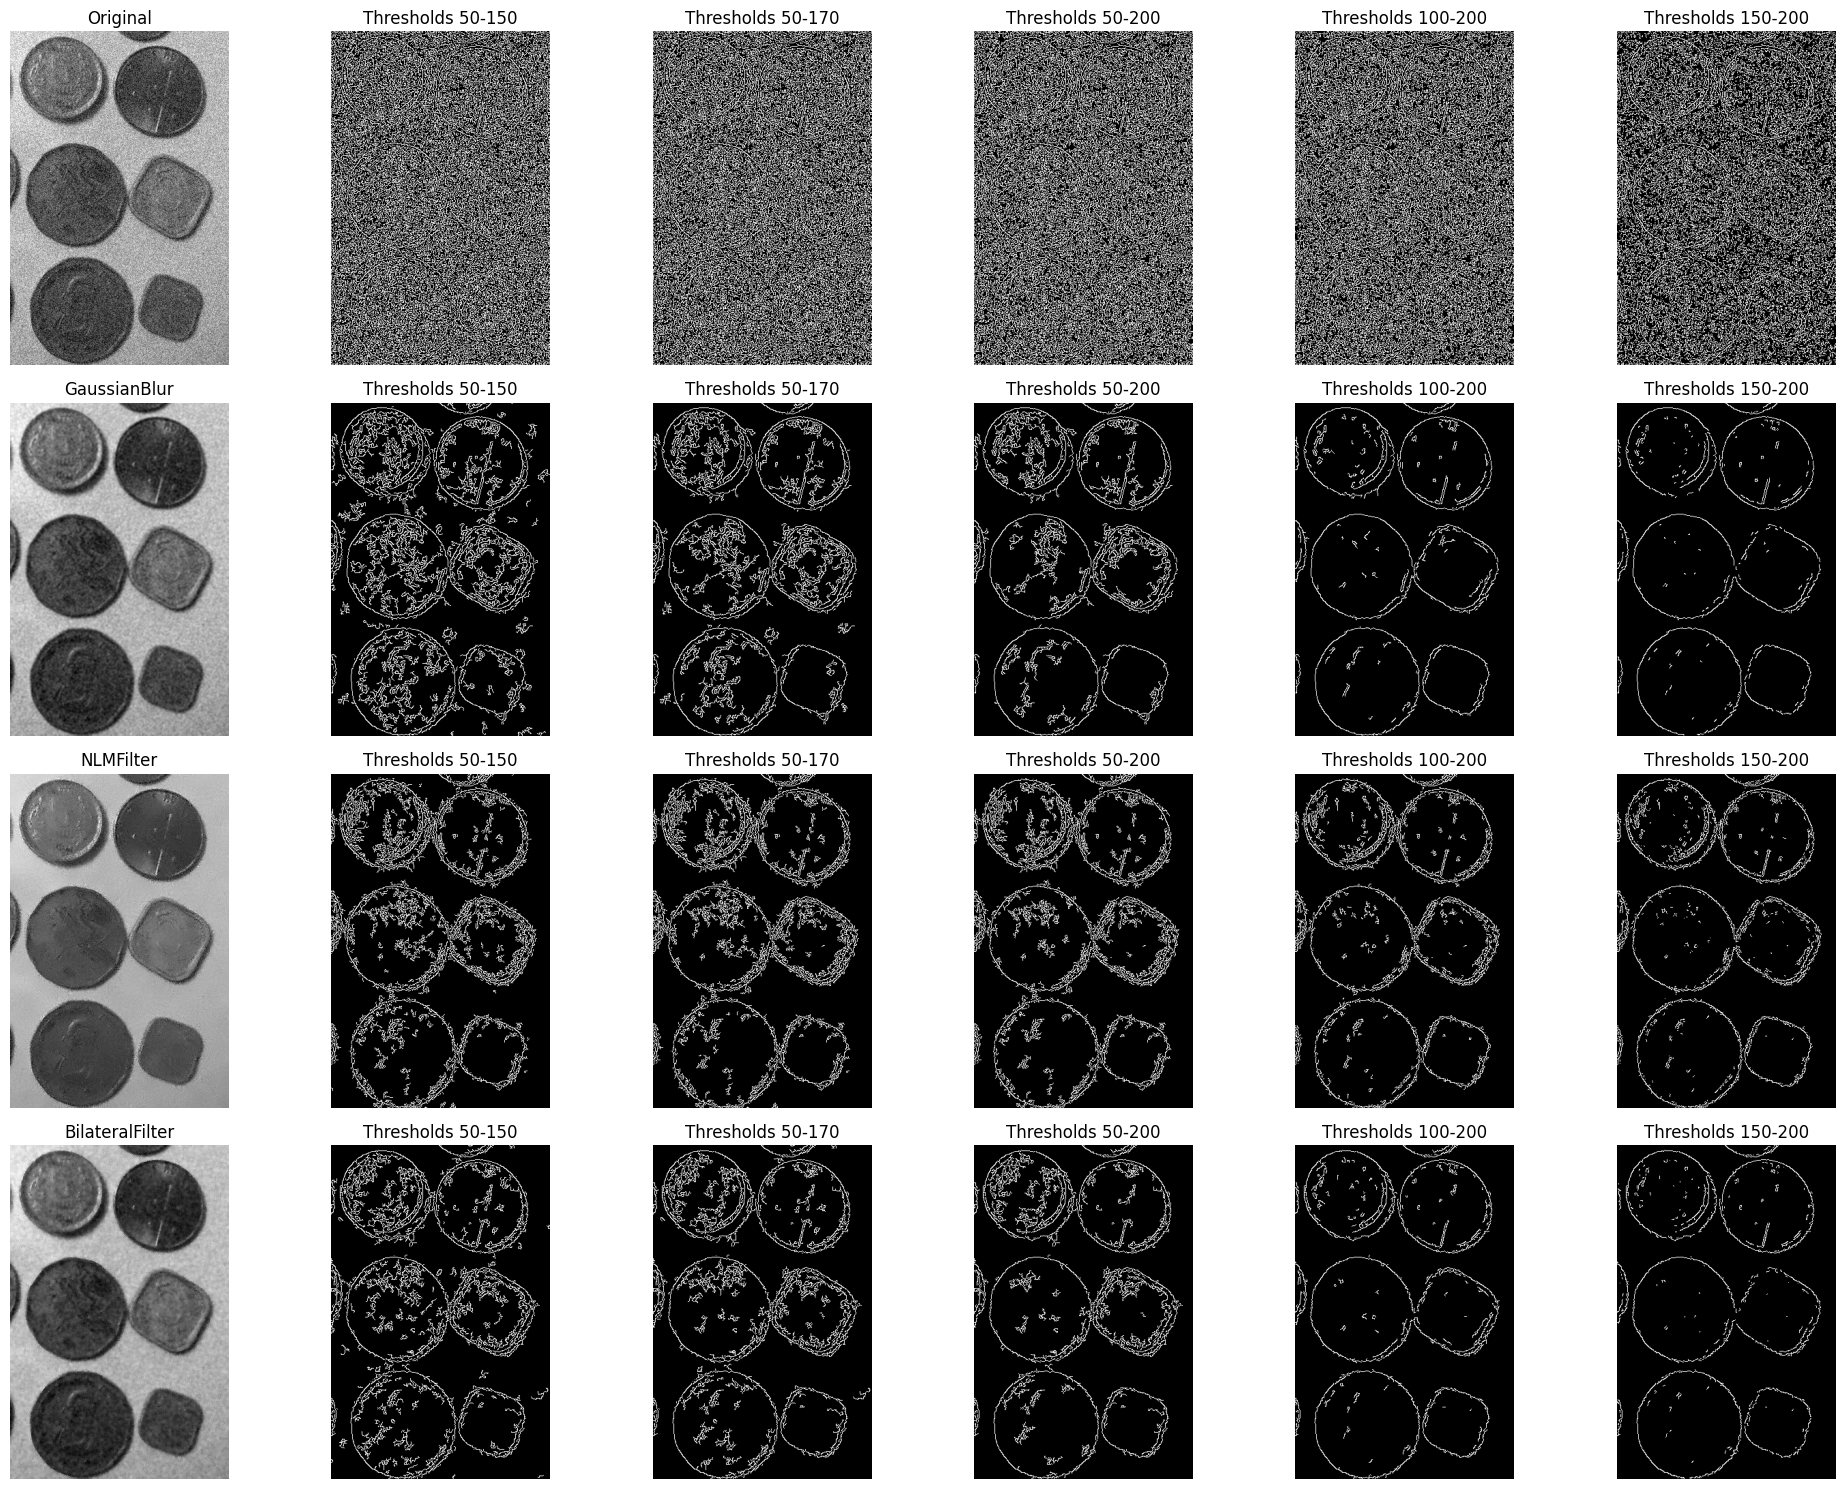

In [6]:
filters = {
    "Original": coins_noise,
    "GaussianBlur": cv2.GaussianBlur(coins_noise, (5, 5), 1),
    "NLMFilter": cv2.fastNlMeansDenoising(coins_noise, None, 18, 7, 20),
    "BilateralFilter": cv2.bilateralFilter(coins_noise, 7, 50, 50)
}

thresholds = [(50, 150), (50, 170), (50, 200), (100, 200), (150, 200)]

results = {}
for filter_name, filtered_img in filters.items():
    results[filter_name] = [cv2.Canny(filtered_img, low, high) for low, high in thresholds]

num_filters = len(filters)
num_thresholds = len(thresholds)

fig, axs = plt.subplots(num_filters, num_thresholds + 1, figsize=(20, 15))

for i, (filter_name, edges_list) in enumerate(results.items()):
    axs[i, 0].imshow(filters[filter_name], cmap='gray')
    axs[i, 0].set_title(filter_name)
    axs[i, 0].axis('off')
    
    for j, (edges, (low, high)) in enumerate(zip(edges_list, thresholds)):
        axs[i, j + 1].imshow(edges, cmap='gray')
        axs[i, j + 1].set_title(f'Thresholds {low}-{high}')
        axs[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

---

##### Zad. 3: Wyrównanie histogramu

Wyrównaj histogram obrazu `coins_noise`. Wyniki zaprezentuj za pomocą obrazów i towarzyszących im histogramów.

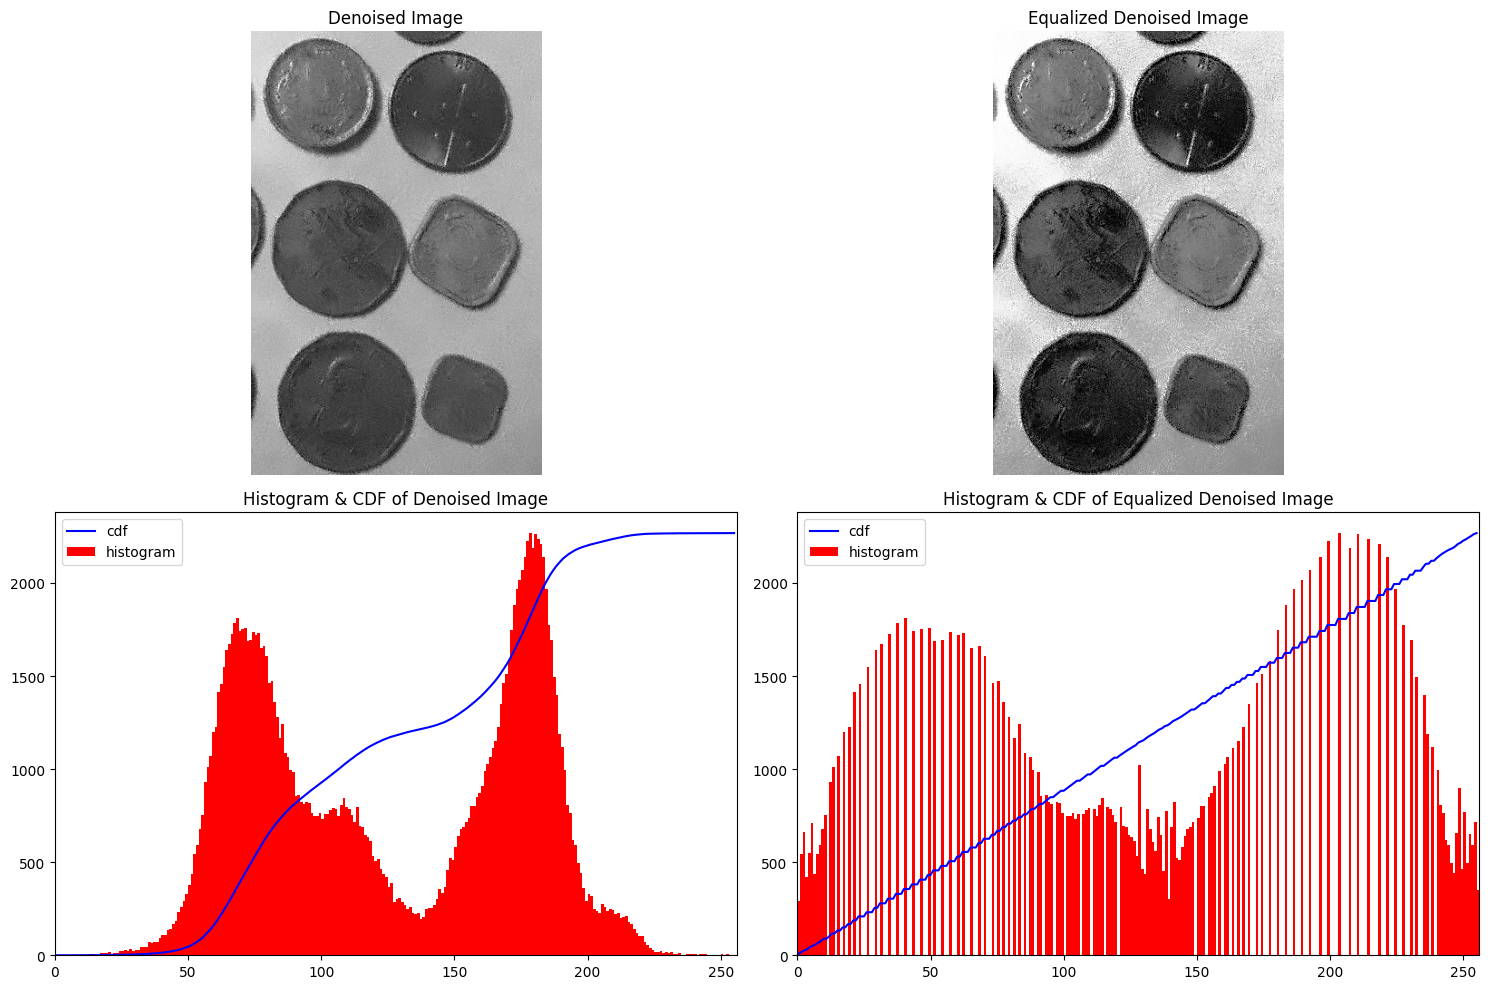

In [11]:
denoised_coins = cv2.fastNlMeansDenoising(coins_noise, None, 18, 7, 20)

equalized_denoised_coins = cv2.equalizeHist(denoised_coins)

def plot_hist_and_cdf(img, ax, title):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    ax.plot(cdf_normalized, color='b')
    ax.hist(img.flatten(), 256, [0, 256], color='r')
    ax.set_xlim([0, 256])
    ax.legend(('cdf', 'histogram'), loc='upper left')
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(denoised_coins, cmap='gray')
axs[0, 0].set_title('Denoised Image')
axs[0, 0].axis('off')
plot_hist_and_cdf(denoised_coins, axs[1, 0], 'Histogram & CDF of Denoised Image')

axs[0, 1].imshow(equalized_denoised_coins, cmap='gray')
axs[0, 1].set_title('Equalized Denoised Image')
axs[0, 1].axis('off')
plot_hist_and_cdf(equalized_denoised_coins, axs[1, 1], 'Histogram & CDF of Equalized Denoised Image')

plt.tight_layout()
plt.show()

---

##### Zad. 4: Transformacja do rozkładu docelowego

Dla obrazów `hare_gray` i `hare_color` wykonaj transformacje na składowych S i/lub V modelu HSV, przechodząc do wybranego (założonego) rozkładu docelowego, tak aby zmaksymalizować możliwość wyodrębnienia obiektu z otoczenia (zająca) przy użyciu algorytmu binaryzacji Otsu.

Podpowiedź: przedstawiona we wstępie teoretycznym transformacja obu rozkładów (źródłowego i docelowego) do rozkładu jednostajnego _nie musi_ zostać faktycznie wykonana (dlatego nie używaj w zadaniu funkcji `cv2.equalizeHist`)! Wystarczy porównywanie ze sobą wartości ze skumulowanych rozkładów (rysunek 3).

Podpowiedź 2: [cv2.LUT](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f)

**4A** (`hare_gray`):

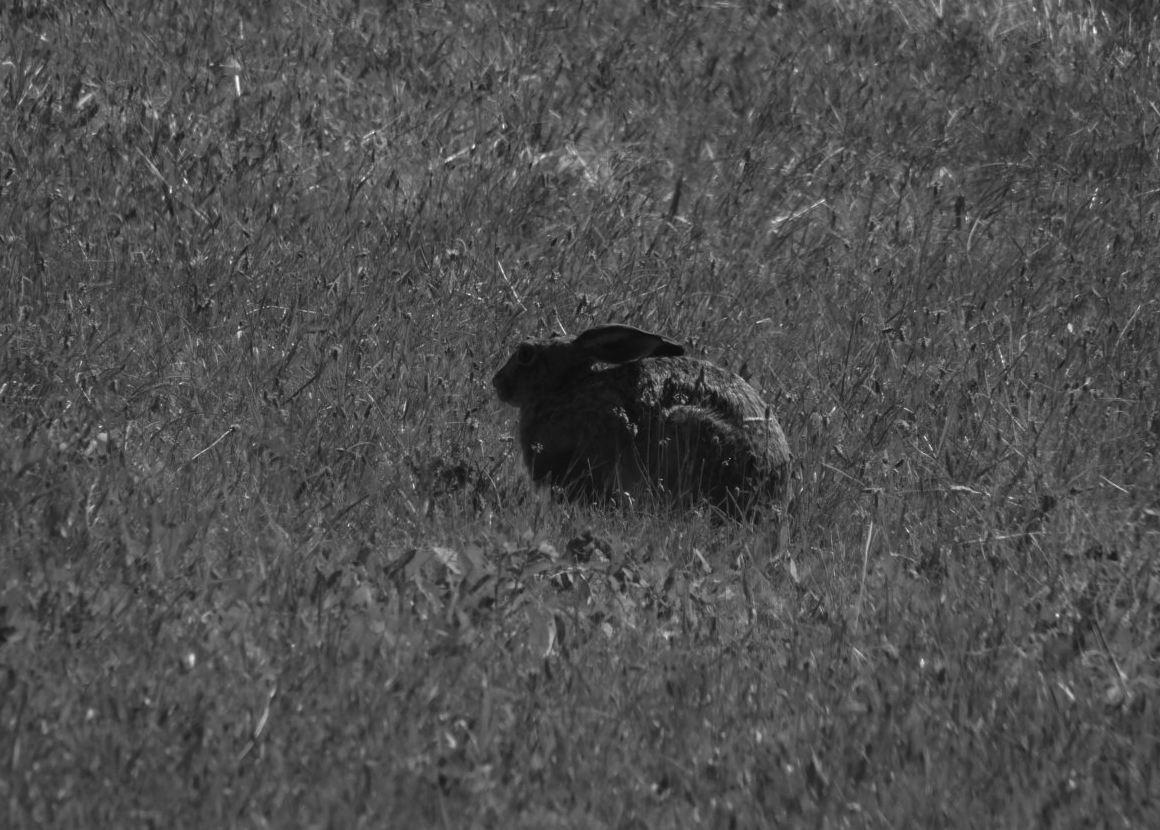

In [2]:
hare_gray = cv2.imread('Zajac.jpg', cv2.IMREAD_GRAYSCALE)
Image.fromarray(hare_gray)

Rozwiązanie:

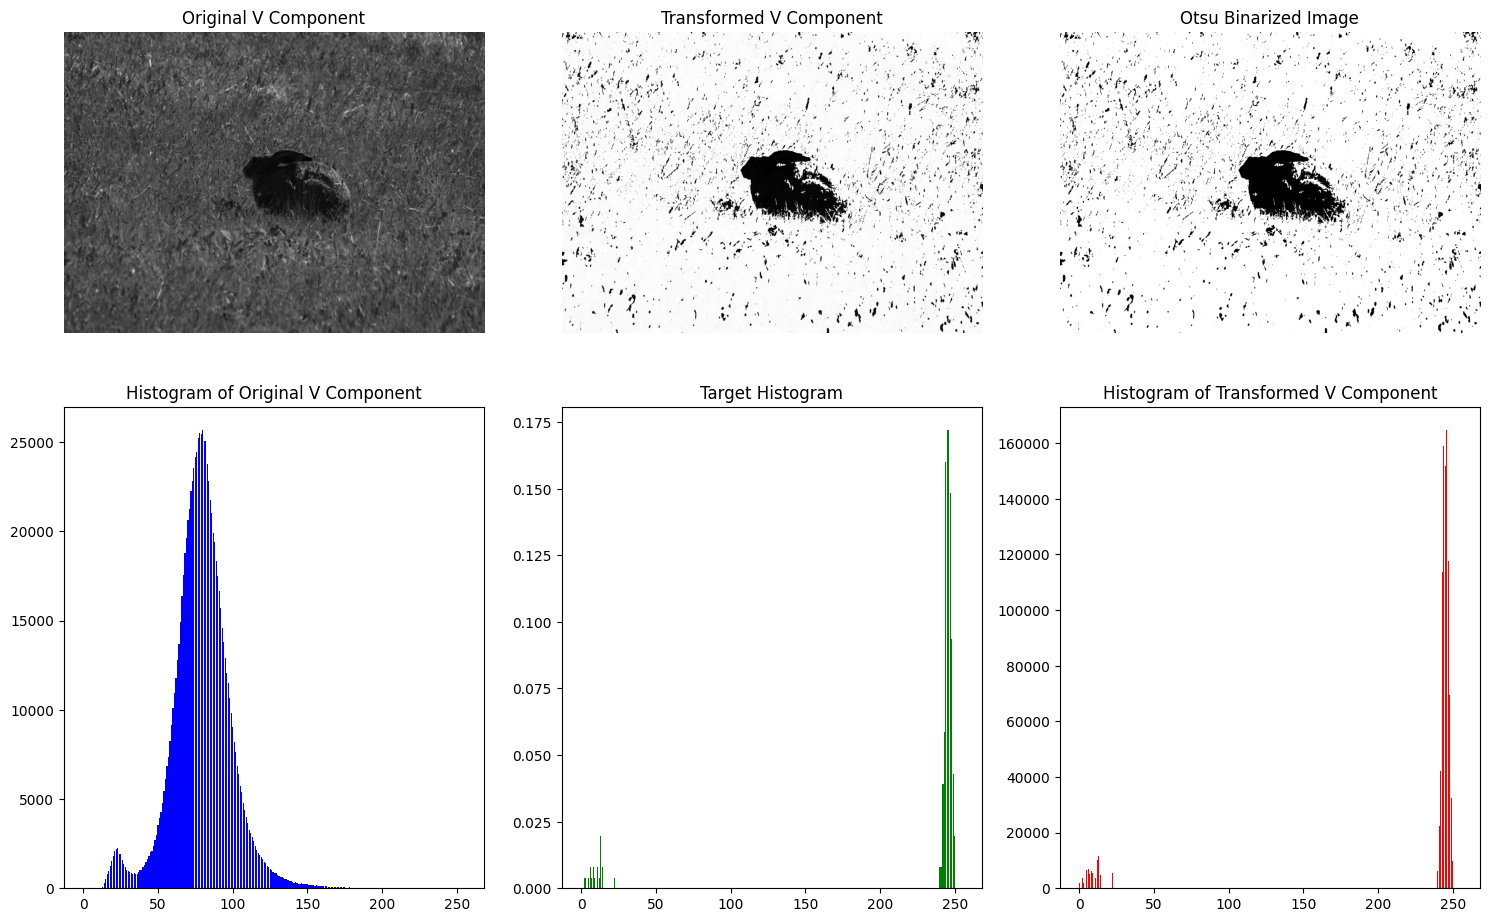

In [21]:
import math 
hare_bgr = cv2.cvtColor(hare_gray, cv2.COLOR_GRAY2BGR)
hare_hsv = cv2.cvtColor(hare_bgr, cv2.COLOR_BGR2HSV)

p = 0.08
mu, sigma = 10, 5
mu2, sigma2 = 245, 2
d1 = np.random.normal(mu, sigma, math.floor(256 * p))
d2 = np.random.normal(mu2, sigma2, math.ceil(256 * (1 - p)))
d = np.concatenate([d1, d2])

hist_target, _ = np.histogram(d, bins=256, range=(0, 255))
hist_target = hist_target.astype('float32')

hist_target /= hist_target.sum()

cdf_target = hist_target.cumsum()
cdf_target /= cdf_target[-1]

def compute_cdf(image):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    return cdf_normalized

cdf_source = compute_cdf(hare_hsv[:, :, 2])

def create_lut(source_cdf, target_cdf):
    lut = np.zeros(256)
    for i in range(256):
        diff = source_cdf[i] - target_cdf
        abs_diff = np.abs(diff)
        lut[i] = np.argmin(abs_diff)
    return lut.astype('uint8')

lut = create_lut(cdf_source, cdf_target)

transformed_V = cv2.LUT(hare_hsv[:, :, 2], lut)

hare_hsv_transformed = hare_hsv.copy()
hare_hsv_transformed[:, :, 2] = transformed_V

hare_transformed_bgr = cv2.cvtColor(hare_hsv_transformed, cv2.COLOR_HSV2BGR)
hare_transformed_gray = cv2.cvtColor(hare_transformed_bgr, cv2.COLOR_BGR2GRAY)

original_hist, _ = np.histogram(hare_hsv[:, :, 2], bins=256, range=(0, 256))
transformed_hist, _ = np.histogram(transformed_V, bins=256, range=(0, 256))

_, hare_bin = cv2.threshold(hare_transformed_gray, 0, 255, cv2.THRESH_OTSU)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(hare_hsv[:, :, 2], cmap='gray')
plt.title('Original V Component')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(transformed_V, cmap='gray')
plt.title('Transformed V Component')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(hare_bin, cmap='gray')
plt.title('Otsu Binarized Image')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.bar(range(256), original_hist, color='blue')
plt.title('Histogram of Original V Component')

plt.subplot(2, 3, 5)
plt.bar(range(256), hist_target, color='green')
plt.title('Target Histogram')

plt.subplot(2, 3, 6)
plt.bar(range(256), transformed_hist, color='red')
plt.title('Histogram of Transformed V Component')

plt.tight_layout()
plt.show()

---

**4B** (`hare_color`):

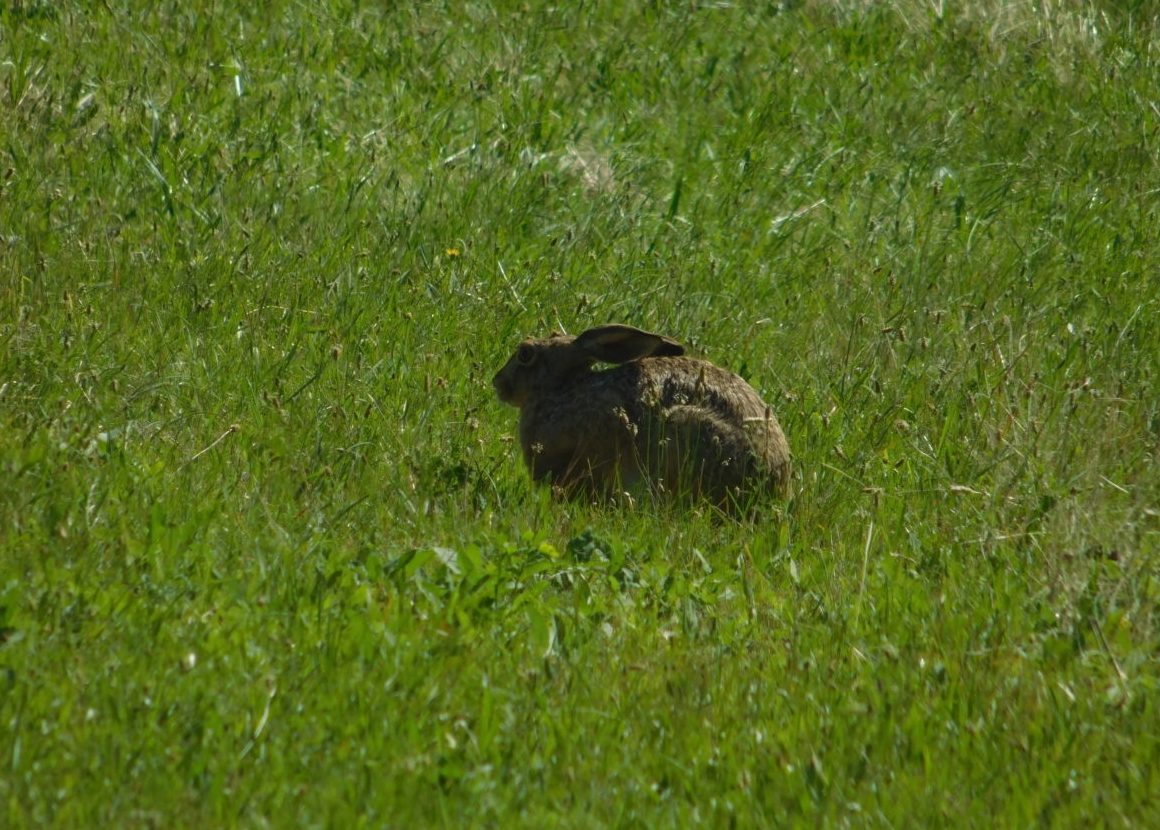

In [22]:
hare_color = cv2.imread('Zajac_kolor.jpg')
Image.fromarray(hare_color[..., ::-1])

Rozwiązanie:

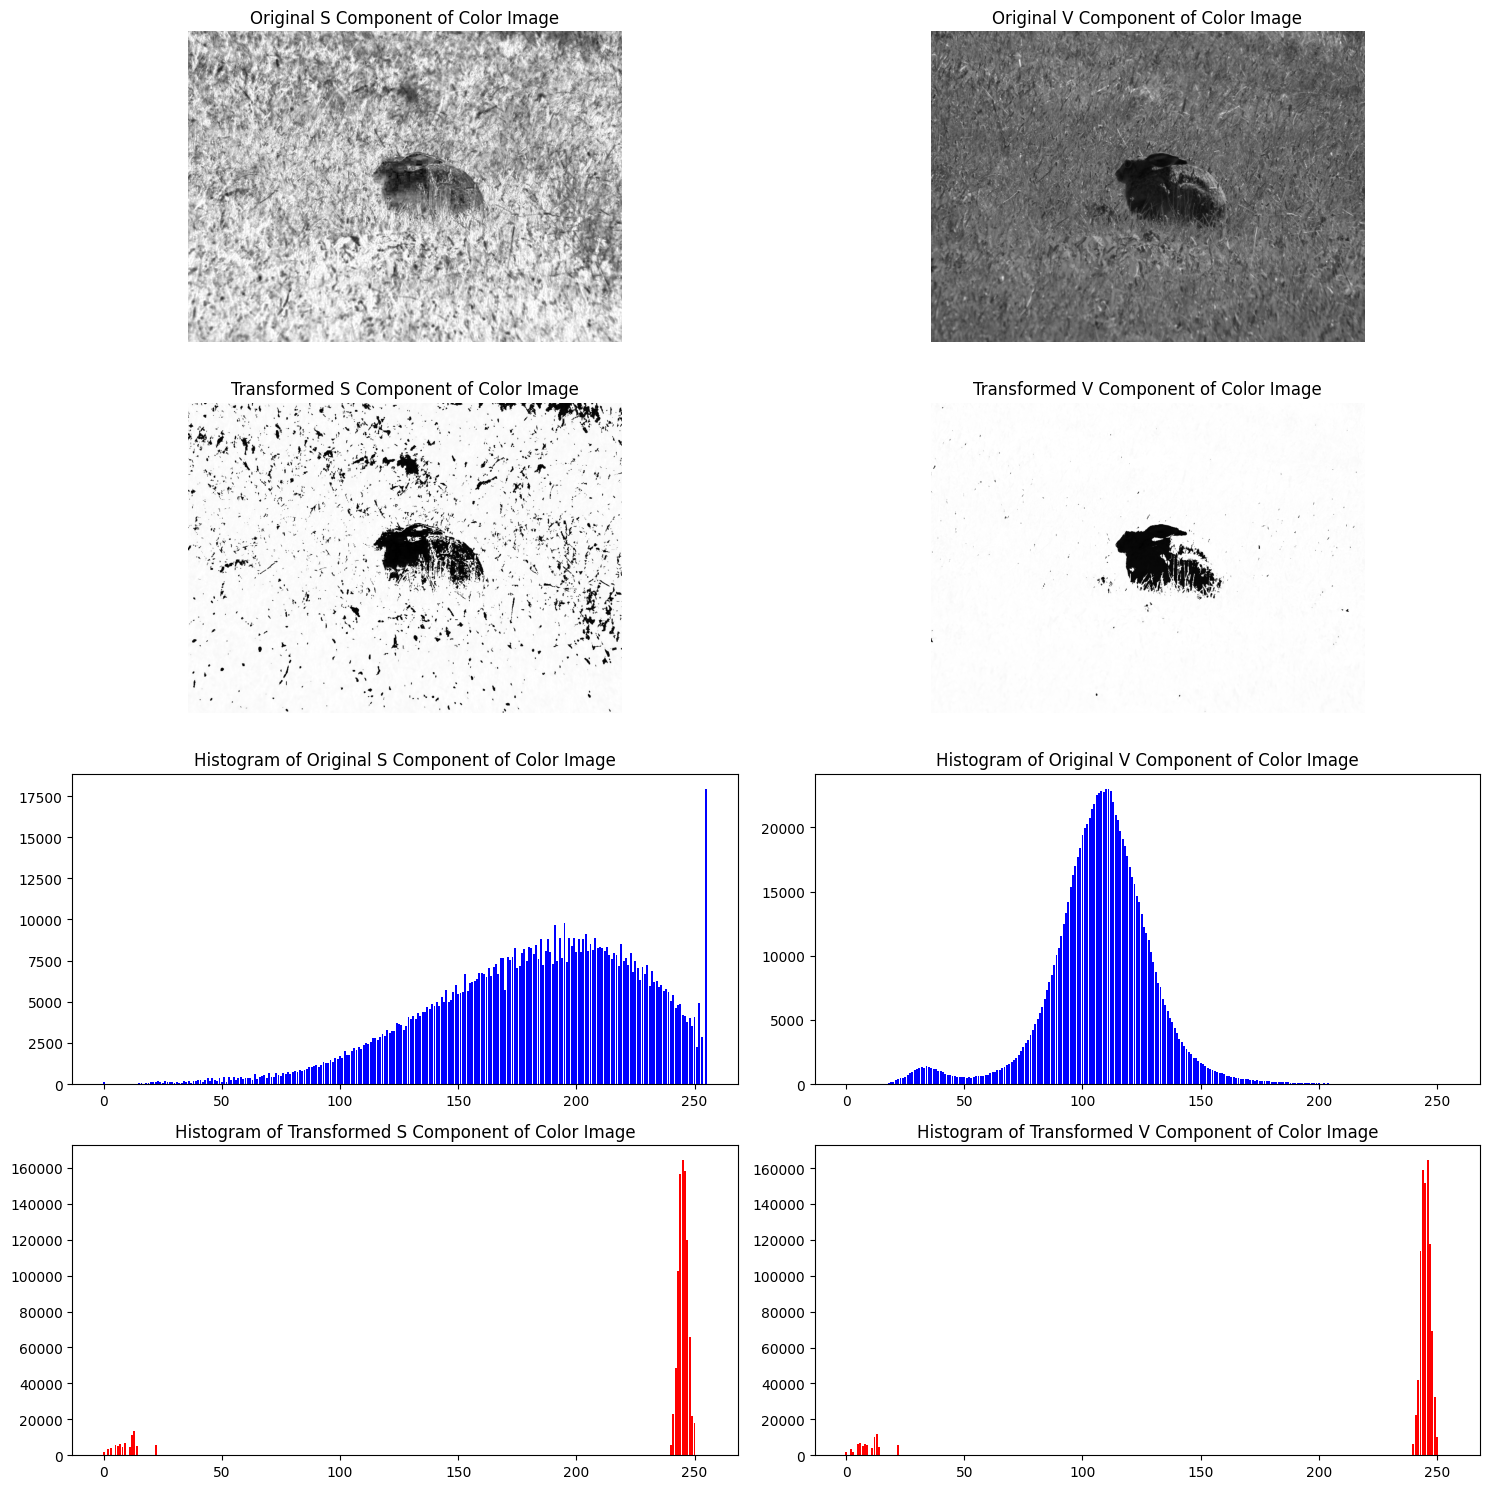

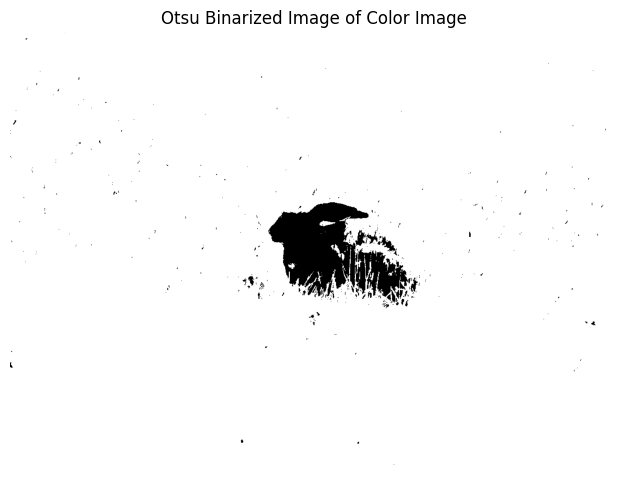

In [29]:
hare_hsv_color = cv2.cvtColor(hare_color, cv2.COLOR_BGR2HSV)

cdf_source_s = compute_cdf(hare_hsv_color[:,:,1])
lut_s = create_lut(cdf_source_s, cdf_target)
transformed_S = cv2.LUT(hare_hsv_color[:,:,1], lut_s)

transformed_V = cv2.LUT(hare_hsv_color[:,:,2], lut)

hare_hsv_transformed_color = hare_hsv_color.copy()
hare_hsv_transformed_color[:,:,1] = transformed_S
hare_hsv_transformed_color[:,:,2] = transformed_V

hare_transformed_bgr = cv2.cvtColor(hare_hsv_transformed_color, cv2.COLOR_HSV2BGR)
hare_transformed_gray_color = cv2.cvtColor(hare_transformed_bgr, cv2.COLOR_BGR2GRAY)

_, hare_bin_color = cv2.threshold(hare_transformed_gray_color, 0, 255, cv2.THRESH_OTSU)

original_hist_v, _ = np.histogram(hare_hsv_color[:,:,2], bins=256, range=(0, 256))
original_hist_s, _ = np.histogram(hare_hsv_color[:,:,1], bins=256, range=(0, 256))
transformed_hist_s, _ = np.histogram(transformed_S, bins=256, range=(0, 256))
transformed_hist_v, _ = np.histogram(transformed_V, bins=256, range=(0, 256))

plt.figure(figsize=(15, 15))

plt.subplot(4, 2, 1)
plt.imshow(hare_hsv_color[:,:,1], cmap='gray')
plt.title('Original S Component of Color Image')
plt.axis('off')

plt.subplot(4, 2, 3)
plt.imshow(transformed_S, cmap='gray')
plt.title('Transformed S Component of Color Image')
plt.axis('off')

plt.subplot(4, 2, 2)
plt.imshow(hare_hsv_color[:,:,2], cmap='gray')
plt.title('Original V Component of Color Image')
plt.axis('off')

plt.subplot(4, 2, 4)
plt.imshow(transformed_V, cmap='gray')
plt.title('Transformed V Component of Color Image')
plt.axis('off')

plt.subplot(4, 2, 6)
plt.bar(range(256), original_hist_v, color='blue')
plt.title('Histogram of Original V Component of Color Image')

plt.subplot(4, 2, 5)
plt.bar(range(256), original_hist_s, color='blue')
plt.title('Histogram of Original S Component of Color Image')


plt.subplot(4, 2, 7)
plt.bar(range(256), transformed_hist_s, color='red')
plt.title('Histogram of Transformed S Component of Color Image')

plt.subplot(4, 2, 8)
plt.bar(range(256), transformed_hist, color='red')
plt.title('Histogram of Transformed V Component of Color Image')

plt.tight_layout()
plt.show()

plt.imshow(hare_bin_color, cmap='gray')
plt.title('Otsu Binarized Image of Color Image')
plt.axis('off')
plt.tight_layout()
plt.show()
